# Imports

In [15]:
import numpy as np
import os
import pandas as pd
idx = pd.IndexSlice
from matplotlib import pyplot as plt
import sys
sys.path.append('generalization')
from modules.integration import Integration
from modules.useful_functions import *
from modules.integration_functions import *
from scipy import stats
from random import seed, sample, shuffle
import warnings
import statsmodels.api as sm
import seaborn as sns
from ax.service.utils.report_utils import exp_to_df
from itertools import combinations
from statsmodels.stats.outliers_influence import variance_inflation_factor
import datetime
import matplotlib.ticker as mtick

# Price class

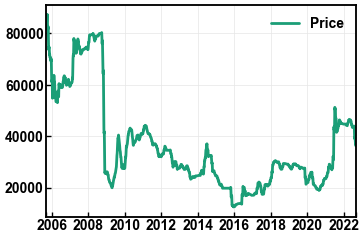

In [2]:
additional_daily = pd.read_excel('data/Price inputs.xlsx',index_col=0,thousands=',',sheet_name='Molybdenum')
additional_daily.index = [year_decimal_to_datetime(j) for j in additional_daily.index]
additional_daily = additional_daily.resample('D').mean().drop_duplicates().dropna().plot()

In [72]:
# def plot_and_regress(commodity='Gold'):
class Price():
    def __init__(self,commodity,verbosity=2):
        self.commodity = commodity
        self.verbosity = verbosity
        self.log = None
        self.vif_limit = 100
        self.commodity_number = 0
        self.price_results = pd.DataFrame()
        self.sheet_list = ['Tin','Gold','Silver','Palladium','Platinum','Zinc','Nickel','Copper','Aluminum','Lead','Iron ore','Steel','Cobalt','Molybdenum']
        self.case_study_data = pd.read_excel('generalization/input_files/user_defined/case study data.xlsx',index_col=0)
        if 'Description' in self.case_study_data.columns: self.case_study_data.drop('Description',axis=1,inplace=True)
        self.goal_commodities = [i for i in self.case_study_data.columns if 'notes' not in i.lower() and i!='Module']
        self.sp_data = pd.read_excel('generalization/input_files/user_defined/Price inputs.xlsx',sheet_name='LME-SP Global',index_col=0)
        self.case_study_data = pd.read_excel('generalization/input_files/user_defined/case study data.xlsx',index_col=0)

        self.use_sp = True
        self.get_sp_map()
        # ^ list of commodity sheets for getting prices up to 2019
        self.m_dict = {}
        self.exclude_cpi = False
        
    def get_sp_map(self):
        self.lowercase_map = {'Al':'aluminum', 'Steel':'steel', 'Au':'gold', 'Co':'cobalt', 'REEs':'rees', 'W':'tungstate', 'Sn':'tin', 'Ta':'tantalum', 'Cu':'copper', 
                         'Ni':'nickel', 'Ag':'silver', 'Zn':'zinc', 'Pb':'lead', 'Mo':'molybdenum', 'Pt':'platinum', 'Te':'tellurium', 'Li':'lithium', 'Li2':'lithium', 'Pd':'palladium'}
        self.commodity_sp_map = {}
        for j in self.goal_commodities:
            if j in self.lowercase_map:
                commodity=self.lowercase_map[j].capitalize()
            else:
                commodity = j
            if commodity=='aluminum': commodity='aluminium'
            sp_map = [i for i in self.sp_data.columns if commodity in i and '$' in i and np.all([j not in i for j in ['3M','58%','EXW','88.5%','Asia','Europe','America','North','Crbnate','WO3']])]
            if commodity.lower()=='rees':
                sp_map = 'Cerium Oxide 99%min FOB China ($/tonne)'
            elif commodity=='Tellurium':
                sp_map = ''
            elif commodity=='Tungsten':
                sp_map = 'Tungstate APT CIF ($/tonne)'
            elif len(sp_map)==0:
                print(j,'not currently supported, need to update the Price inputs file with price corresponding to your commodity, using its name as the price name')
                self.goal_commodities = [q for q in self.goal_commodities if q!=j]
            else:
                sp_map = sp_map[0]
            self.commodity_sp_map[commodity] = sp_map
        
    def load_data(self):
        commodity = self.commodity
        
        if commodity=='Steel':
            price_daily=pd.read_excel('generalization/input_files/user_defined/Price inputs.xlsx',sheet_name='Steel long hist',index_col=0)['Price'].dropna().sort_index()
            price_daily.name = commodity
            price_daily = self.update_price_daily_to_include_2019(price_daily,commodity)
        elif not self.use_sp or commodity in ['Tellurium','Palladium']:
            price_daily=pd.read_excel('generalization/input_files/user_defined/Price inputs.xlsx',sheet_name='AMM',index_col=0)[commodity].iloc[1:].dropna().sort_index()
        else:
            price_daily=self.sp_data[self.commodity_sp_map[commodity]].dropna().sort_index()
            price_daily.name = commodity
            # Cr, Co, Li, Mn, Mo, Pd, Ta, REEs, Y are all still lacking in historical data
        if commodity in ['Silver'] and not self.use_sp:
            price_daily *= 352.74
        elif commodity in ['Gold','Platinum','Palladium','Silver']:
            price_daily *= 35274
        elif commodity in ['Tantalum']:
            price_daily *= 1e3
            additional_daily = pd.read_excel('generalization/input_files/user_defined/Price inputs.xlsx',index_col=0,thousands=',',sheet_name=commodity)['Price']
            add_to = additional_daily.resample('AS').mean().loc['20090101']-price_daily.resample('AS').mean().loc['20090101']
            additional_daily-=add_to
            price_daily = pd.concat([
                additional_daily.loc[[i for i in additional_daily.index if i<price_daily.index[0]]],
                price_daily])
            price_daily.name = commodity
        price_daily.index = pd.to_datetime(price_daily.index)
        if not self.use_sp:
            price_daily = self.update_price_daily_to_include_2019(price_daily,commodity)
        price_daily = price_daily[price_daily>0]
        
        price_monthly = price_daily.resample('MS').mean()
        oil_price_daily = pd.read_excel('generalization/input_files/user_defined/Price inputs.xlsx',sheet_name='Oil',index_col=0).iloc[1:,0].dropna().sort_index()
        oil_price_daily.index = pd.to_datetime(oil_price_daily.index)
        oil_price_monthly = oil_price_daily.resample('MS').mean()
        cpi_monthly = pd.read_excel('generalization/input_files/user_defined/Price inputs.xlsx',sheet_name='CPI',index_col=0).loc[:,:'Dec'].iloc[1:].stack().dropna()
        cpi_monthly.index = [str(i[0])+'-'+i[1] for i in cpi_monthly.index]
        cpi_monthly.index = pd.to_datetime(cpi_monthly.index)
        cpi_monthly = cpi_monthly.sort_index()
        self.deflator = cpi_monthly.copy()/cpi_monthly.resample('AS').mean().loc['20190101']
        gdp_monthly = pd.read_excel('generalization/input_files/user_defined/Price inputs.xlsx',sheet_name='GDP',index_col=0).iloc[1:,0].dropna().sort_index()
        gdp_monthly = gdp_monthly.add(100).mul(1e-2).cumprod()
        gdp_monthly.name = 'GDP norm start'

        if self.exclude_cpi:
            data = pd.concat([price_monthly,oil_price_monthly,gdp_monthly],axis=1).dropna()
        else:
            data = pd.concat([price_monthly,oil_price_monthly,cpi_monthly,gdp_monthly],axis=1).rename(columns={0:'CPI'}).dropna()
        self.deflator = self.deflator.loc[data.index]
        data.loc[:,commodity] /= self.deflator
        data.loc[:,'Oil'] /= self.deflator
        if commodity=='Gold':
            if self.use_sp:
                silver_price_daily = self.sp_data[self.commodity_sp_map['Silver']].dropna().sort_index()
                silver_price_daily.name='Silver'
            else:
                silver_price_daily=pd.read_excel('generalization/input_files/user_defined/Price inputs.xlsx',sheet_name='AMM',index_col=0)['Silver'].iloc[1:].dropna().sort_index()
                silver_price_daily.index = pd.to_datetime(silver_price_daily.index)
                silver_price_daily = self.update_price_daily_to_include_2019(silver_price_daily,'Silver')
            silver_price_monthly = silver_price_daily.resample('MS').mean()
            data = pd.concat([data,silver_price_monthly],axis=1).dropna()
            data.loc[:,'Silver'] /= self.deflator
        elif commodity=='Silver':
            if self.use_sp:
                gold_price_daily = self.sp_data[self.commodity_sp_map['Gold']].dropna().sort_index()
                gold_price_daily.name='Gold'
            else:
                gold_price_daily=pd.read_excel('generalization/input_files/user_defined/Price inputs.xlsx',sheet_name='AMM',index_col=0)['Gold'].iloc[1:].dropna().sort_index()
                gold_price_daily.index = pd.to_datetime(gold_price_daily.index)
                gold_price_daily = self.update_price_daily_to_include_2019(gold_price_daily,'Gold')
            gold_price_monthly = gold_price_daily.resample('MS').mean()
            data = pd.concat([data,gold_price_monthly],axis=1).dropna()
            data.loc[:,'Gold'] /= self.deflator
            
        # data.loc[:,'First lag'] = data[commodity].shift(1)
        # data = data.dropna()
        
        self.data = data.copy()
        self.orig_data = data.copy()
        self.price_daily = price_daily.copy()
    
    def update_price_daily_to_include_2019(self, price_daily, commodity):
        '''
        
        '''
        if commodity in self.sheet_list:
            additional_daily = pd.read_excel('generalization/input_files/user_defined/Price inputs.xlsx',index_col=0,thousands=',',sheet_name=commodity)
            self.additional_daily = additional_daily.copy()
            if commodity in ['Cobalt','Molybdenum']:
                additional_daily.index = [year_decimal_to_datetime(j) for j in additional_daily.index]
                additional_daily = additional_daily.resample('D').mean().drop_duplicates().dropna()
            daily2 = additional_daily['Price'].copy()
            daily2.index = pd.to_datetime(daily2.index)
            daily2 = daily2.sort_index()
            daily1 = price_daily.copy().sort_index()
            both_og = pd.concat([daily1,daily2],axis=1,keys=['AMM','Investing']).dropna().astype(float)
            if self.verbosity>2:
                train = both_og.copy().iloc[:int(both_og.shape[0]*0.6)]
                test = both_og.copy().loc[~both_og.index.isin(train.index)]
                m = sm.GLS(train['AMM'],sm.add_constant(train['Investing'])).fit(cov_type='HC3')
                fig,ax = easy_subplots(1)
                predict = m.predict(sm.add_constant(test['Investing']))
                test['AMM'].resample('MS').mean().plot(ax=ax[0],label='Actual')
                predict.resample('MS').mean().plot(label='Predicted',ax=ax[0],title='Result of using data from investing.com to predict\n0.6 training fraction, resampled to monthly\n'+r'$R^2$'+': {:.3f}'.format(m.rsquared))
                ax[0].set(title=commodity)
                ax[0].legend()
                plt.show()
            train = both_og.copy()
            test = daily2.loc[daily2.index>train.index[-1]]
            m = sm.GLS(train['AMM'],sm.add_constant(train['Investing'])).fit(cov_type='HC3')
            predict = m.predict(sm.add_constant(test))
            price_daily = pd.concat([daily1,predict])
            price_daily.name = commodity
        return price_daily
            
    def find_best_regression(self,log,verbosity=2):
        if verbosity>0:
            if log: print(f'Running regression on LOGGED data for {self.commodity}')
            else: print(f'Running regression on DIFFERENCED data for {self.commodity}')
        self.log = log
        commodity = self.commodity
        data = self.orig_data.copy()
        orig_data = self.orig_data.copy()
        
        if log:
            data.loc[:,(data>0).all()] = np.log(data.loc[:,(data>0).all()].astype(float))
        else:
            data = data.diff().dropna()
        data = data.astype(float)

        # finding best regression
        cols = [i for i in data.columns if i!=commodity]
        combos = [list(combinations(cols,i)) for i in np.arange(2,len(cols)+1)]
        combos = [i[j] for i in combos for j in np.arange(len(i))]
        results = pd.DataFrame()
        data_relabeled = data.copy()
        
        data_relabeled.columns = ['log('+i+')' if log else 'diff('+i+')' for i in data_relabeled.columns]
        for e,i in enumerate(combos):
            m = sm.GLS(data[commodity], sm.add_constant(data.loc[:,i])).fit(cov_type='HC3')
            results.loc[e,'aic'] = m.aic
            results.loc[e,'bic'] = m.bic
            results.loc[e,'rsquared'] = m.rsquared
            results.loc[e,'m'] = m
            vif = max([variance_inflation_factor(data.loc[:,i].values, j) for j in range(data.loc[:,i].shape[1])])
            results.loc[e,'vif'] = vif
            for e2,j in enumerate(i):
                results.loc[e,'param'+str(e2)] = j
        
        if (results['vif']<self.vif_limit).any():
            vif_removed_results = results.loc[results['vif']<self.vif_limit]
        else: vif_removed_results = results.copy()
        if verbosity>0:
            if (results['vif']>self.vif_limit).all():
                min_vif = round(results['vif'].min(),2)
                print(f'all regressions attempted here are strongly multi-collinear, with smallest VIF of {min_vif}; all regressions are available for use as self.m and plotting')
            elif (results['vif']>10).sum()>0 and vif_removed_results['aic'].idxmin()!=results['aic'].idxmin():
                best_vif = round(vif_removed_results['vif'][vif_removed_results['aic'].idxmin()],2)                
                print(f'best-performing regression is highly multi-collinear with VIF>{self.vif_limit}; this regression has been rejected and self.m/plots use\nthe best regression after excluding high-VIF regressors; the new best-performing regression has maximum VIF of {best_vif}')
            else:
                best_vif = round(results['vif'][results['aic'].idxmin()],2)
                print(f'best-performing regression is NOT sufficiently multi-collinear to be rejected; its maximum VIF is {best_vif}')
        m = results.loc[vif_removed_results.aic.idxmin(),'m']
        
        param_cols = [i for i in results.columns if 'param' in i]
        best_cols = results.loc[vif_removed_results['aic'].idxmin(),param_cols].dropna().values
        best_cols = ['log('+i+')' if log else 'diff('+i+')' for i in best_cols]
        self.commodity_relabeled = 'log('+commodity+')' if log else 'diff('+commodity+')'
        new_m = sm.GLS(data_relabeled[self.commodity_relabeled], sm.add_constant(data_relabeled.loc[:,best_cols])).fit(cov_type='HC3')
        if verbosity > 0:
            display(new_m.summary())
            
        self.orig_data = orig_data.copy()
        self.data = data.copy()
        self.results = results.copy()
        self.m = m
        log_str = 'log' if log else 'diff'
        self.m_dict[f'{commodity} {log_str}'] = m

    def adjust_prices(self, log):
        if self.log==None or log!=self.log:
            self.find_best_regression(log)
        orig_data = self.orig_data.copy()
        data = self.data.copy()
        results = self.results.copy()
        m = self.m
        commodity = self.commodity

        
        adjusted = data[commodity].copy()
        if 'const' in m.params.index and m.pvalues['const']<=0.1:
            adjusted -= m.params['const']
        for i in np.intersect1d(data.columns,m.params.index):
            if m.pvalues[i]<=0.1: adjusted -= data[i]*m.params[i]

        if log:
            if commodity in self.sheet_list:
                adjusted += data[commodity].loc['20190101']-adjusted.loc['20190101']
            else:
                adjusted += data[commodity].loc['20180101']-adjusted.loc['20180101']
            adjusted_exp = np.exp(adjusted)
        else: 
            adjusted = adjusted.cumsum()+orig_data[commodity].iloc[0]
            if commodity in self.sheet_list:
                adjusted += orig_data[commodity].loc['20190101']-adjusted.loc['20190101']
            else:
                adjusted += orig_data[commodity].loc['20180101']-adjusted.loc['20180101']
            adjusted_exp = adjusted.copy()

        if self.verbosity>1:
            fig,ax = easy_subplots(2)
            if log:
                np.exp(data[commodity]).plot(ax=ax[0],label='Original')
            else:
                (orig_data[commodity]).plot(ax=ax[0],label='Original')
            adjusted_exp.plot(ax=ax[0],label='Adjusted').grid(axis='x')
            ax[0].legend()

        if log:
            orig_annual = np.exp(data[commodity]).resample('YS').mean()#.loc['20010101':]
        else:
            orig_annual = (orig_data[commodity]).resample('YS').mean()#.loc['20010101':]
        orig_annual.index = [int(str(i).split('-')[0]) for i in orig_annual.index]
        adjusted_exp_annual = adjusted_exp.resample('YS').mean()#.loc['20010101':]
        adjusted_exp_annual.index = [int(str(i).split('-')[0]) for i in adjusted_exp_annual.index]
        if commodity in self.sheet_list:
            adjusted_exp_annual += orig_annual.loc[2019]-adjusted_exp_annual.loc[2019]
        else:
            adjusted_exp_annual += orig_annual.loc[2018]-adjusted_exp_annual.loc[2018]
        
        if self.verbosity>1:
            orig_annual.plot(ax=ax[1],label='Original')
            adjusted_exp_annual.plot(ax=ax[1],label='Adjusted').grid(axis='x')
            ax[1].legend()
            fig.tight_layout()
            
            ax[0].set(title=self.commodity_relabeled+' monthly')
            ax[1].set(title=self.commodity_relabeled+' annual')
            plt.show()

        output_price = pd.DataFrame(adjusted_exp_annual)
        output_price = output_price.rename(columns={output_price.columns[0]:self.commodity_relabeled})
        for i in output_price.columns:
            if i in self.price_results.columns: self.price_results.drop(i,inplace=True,axis=1)
        self.price_results = pd.concat([self.price_results, output_price],axis=1)
        
        output_price = pd.DataFrame(orig_annual)
        output_price = output_price.rename(columns={output_price.columns[0]:self.commodity+' original'}).sort_index()
        for i in output_price.columns:
            if i in self.price_results.columns: self.price_results.drop(i,inplace=True,axis=1)
        self.price_results = pd.concat([self.price_results, output_price],axis=1)
        
    def run(self):
        self.load_data()
        # if self.data.index[0]<datetime.datetime(2001,1,1) and self.data.index[-1]>datetime.datetime(2018,1,1):
        for log in [False,True]:
            self.find_best_regression(log=log,verbosity=self.verbosity)
            self.adjust_prices(log=log)
            if self.verbosity>0: print('-'*50)

    def run_many(self):
        commodities = self.goal_commodities
        self.commodities = commodities
        commodity = commodities[self.commodity_number]
        if commodity in self.lowercase_map:
            self.commodity = self.lowercase_map[commodity].capitalize()
        else:
            self.commodity = commodity
        if self.verbosity>-1 and self.commodity not in self.sheet_list: print(self.commodity+' not adjusted to 2019, but running...')
        elif self.verbosity>-1: print(self.commodity+' running...')
        if self.commodity!='Tellurium':
            self.run()
        self.commodity_number += 1
        
    def run_all(self):
        while True:
            try:
                self.run_many()
            except IndexError:
                break
                
    def generate_regression_result_table(self):
        if not hasattr(self,'m_dict') or len(self.m_dict)==0:
            self.run_all()
        all_concat = pd.DataFrame()
        for i in self.m_dict.keys():
            m = self.m_dict[i]
            if 'diff' in i:
                ind = 'diff('+i.split()[0]+' price)'
            else:
                ind = 'log('+i.split()[0]+' price)'
            to_concat = pd.concat([m.params,m.pvalues],keys=['Coefficient','p-value'],axis=1)
            to_concat.loc['R-squared','Coefficient'] = m.rsquared
            to_concat = pd.concat([to_concat],keys=[ind])
            # all_concat = pd.concat([all_concat,to_concat])

            alt_concat = m.params.copy()
            for j in alt_concat.index:
                alt_concat.loc[j] = str(round(alt_concat[j],3))+' ('+str(round(m.pvalues[j],3))+')'
            alt_concat.rename(dict(zip(alt_concat.index,[j.replace('const','Constant').replace('Oil','Oil price').replace('GDP norm start','GDP').replace('Silver','Silver price').replace('Gold','Gold price') for j in alt_concat.index])),inplace=True)
            alt_concat.loc['R-squared'] = m.rsquared
            alt_concat.loc['R-squared'] = m.rsquared_adj
            alt_concat.loc['No. observations'] = m.nobs
            alt_concat.name = ind
            all_concat = pd.concat([all_concat,alt_concat],axis=1)
        all_concat = all_concat.T
        all_concat = all_concat.astype({'No. observations':int})
        self.all_concat = all_concat.copy()
        display(all_concat.loc[[i for i in all_concat.index if 'log' not in i]])
        display(all_concat.loc[[i for i in all_concat.index if 'log' in i]])
        
# all_concat

In [66]:
mod.orig_data
additional_daily = pd.read_excel('generalization/input_files/user_defined/Price inputs.xlsx',index_col=0,thousands=',',sheet_name='Tantalum')['Price']
add_to = additional_daily.resample('AS').mean().loc['20090101']-mod.orig_data['Tantalum'].resample('AS').mean().loc['20090101']
additional_daily-=add_to
pd.concat([
    mod.orig_data,additional_daily.resample('MS').mean()],axis=1).dropna()

mod.orig_data['Tantalum']
additional_daily.loc[[i for i in additional_daily.index if i<mod.orig_data.index[0]]]

1970-01-01     27290.699185
1970-01-13     27290.691219
1970-01-25     27290.707836
1970-02-07     27290.720906
1970-02-19     27290.634516
                  ...      
2009-05-03    128557.729975
2009-05-15    130453.941411
2009-05-27    132377.013192
2009-06-08    133423.145955
2009-06-20    134278.026981
Name: Price, Length: 1185, dtype: float64

# Individual runs

Running regression on DIFFERENCED data for Tantalum
best-performing regression is NOT sufficiently multi-collinear to be rejected; its maximum VIF is 1.22


<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:         diff(Tantalum)   R-squared:                       0.011
Model:                            GLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.955
Date:                Thu, 16 Feb 2023   Prob (F-statistic):             0.0196
Time:                        11:53:36   Log-Likelihood:                -6925.4
No. Observations:                 623   AIC:                         1.386e+04
Df Residuals:                     620   BIC:                         1.387e+04
Df Model:                           2                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1526.8727    729.338      2.094      0.036      97.397    2956.348
diff(Oil)    316.7952    138.132      2.293      0.022      46.061     587.530
diff(CPI)  -3295.9137   1198.176     -2.751      0.006   -5644.296    -947.531
==============================================================================
Omnibus:                      108.358   Durbin-Watson:                   0.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1263.546
Skew:                          -0.343   Prob(JB):                    4.21e-275
Kurtosis:                       9.943   Cond. No.                         10.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

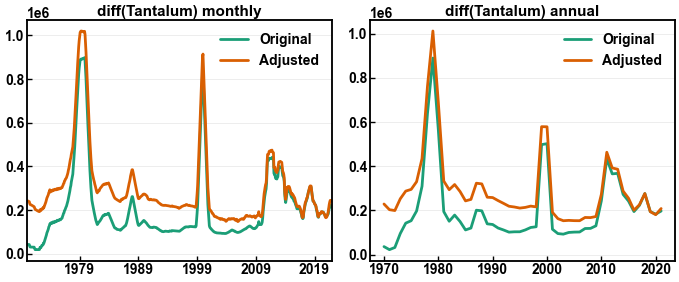

--------------------------------------------------
Running regression on LOGGED data for Tantalum
best-performing regression is NOT sufficiently multi-collinear to be rejected; its maximum VIF is 52.66


<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:          log(Tantalum)   R-squared:                       0.299
Model:                            GLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     99.63
Date:                Thu, 16 Feb 2023   Prob (F-statistic):           2.96e-38
Time:                        11:53:36   Log-Likelihood:                -555.32
No. Observations:                 624   AIC:                             1117.
Df Residuals:                     621   BIC:                             1130.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.4689      0.299     28.292      0.000       7.882       9.056
log(Oil)       0.7143      0.056     12.735      0.000       0.604       0.824
log(CPI)       0.1434      0.052      2.772      0.006       0.042       0.245
==============================================================================
Omnibus:                       52.401   Durbin-Watson:                   0.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.362
Skew:                           0.624   Prob(JB):                     2.62e-17
Kurtosis:                       4.175   Cond. No.                         67.1
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

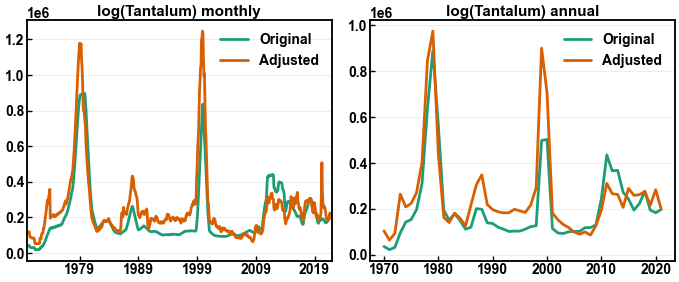

--------------------------------------------------


In [73]:
mod = Price('Tantalum',verbosity=4)
# mod.vif_limit = 1e3
mod.run()

In [682]:
mod.commodity_number=20
mod.run_many()

IndexError: index 20 is out of bounds for axis 0 with size 15

# Running all available

In [164]:
def update_tuned_rmse_df_out_with_new_data(folder_name, element, tuned_rmse_df_out_append, 
                                           generalization_file_path='generalization'):
    m = Many()
    m.load_data(folder_name)
    commodity = m.element_commodity_map[element].lower()
    rmse_ph = m.rmse_df_sorted.stack().unstack(1).rename({element:commodity})
    filename = f'{generalization_file_path}/output_files/tuned_rmse_df_out_{tuned_rmse_df_out_append}.csv'
    tuned = pd.read_csv(filename, index_col=[0,1])
    if commodity in tuned.index.get_level_values(0).unique():
        tuned.drop(commodity,inplace=True)
    rmse = pd.concat([tuned,rmse_ph]).fillna(0)
    rmse.to_csv(filename)
    
update_tuned_rmse_df_out_with_new_data(
    folder_name = '2023-02-16 19_22_18_4_run_hist_all_one_more_time',
    element = 'Ta',
    generalization_file_path = 'generalization',
    tuned_rmse_df_out_append = 'one_more_time',
)


In [74]:
mod = Price('Aluminum',verbosity=0)
mod.exclude_cpi=True
mod.generate_regression_result_table()
mod.price_results.to_csv('generalization/input_files/user_defined/price adjustment results.csv')

Aluminum running...
Steel running...
Gold running...
Tin running...
Copper running...
Nickel running...
Silver running...
Zinc running...
Lead running...
Platinum running...
Tellurium not adjusted to 2019, but running...
Lithium not adjusted to 2019, but running...
Lithium not adjusted to 2019, but running...
Si not adjusted to 2019, but running...
Cobalt running...
Rees not adjusted to 2019, but running...
Tungstate not adjusted to 2019, but running...
Tantalum not adjusted to 2019, but running...
Molybdenum running...


,Constant,Oil price,GDP,R-squared,No. observations,Silver price,Gold price
diff(Aluminum price),-1.373 (0.801),7.111 (0.0),-0.0 (0.91),0.14538,332,NaN,NaN
diff(Steel price),0.976 (0.625),2.209 (0.0),-0.0 (0.924),0.098441,313,NaN,NaN
diff(Gold price),63902.107 (0.184),-42903.46 (0.001),NaN,0.523907,377,773142.237 (0.0),NaN
diff(Tin price),28.324 (0.569),74.094 (0.0),0.0 (0.231),0.14946,394,NaN,NaN
diff(Copper price),10.923 (0.546),31.201 (0.0),-0.0 (0.365),0.192028,377,NaN,NaN
diff(Nickel price),29.509 (0.759),59.546 (0.011),-0.0 (0.959),0.029023,343,NaN,NaN
diff(Silver price),-1058.348 (0.49),2164.104 (0.0),NaN,0.561311,377,NaN,846.07 (0.0)
diff(Zinc price),-0.78 (0.924),4.801 (0.011),-0.0 (0.855),0.020143,394,NaN,NaN
diff(Lead price),3.333 (0.658),5.56 (0.007),-0.0 (0.904),0.042809,343,NaN,NaN
diff(Platinum price),745.39 (0.995),167370.649 (0.0),-0.006 (0.101),0.145472,394,NaN,NaN


,Constant,Oil price,GDP,R-squared,No. observations,Silver price,Gold price
log(Aluminum price),7.873 (0.0),0.367 (0.0),-0.093 (0.0),0.561036,333,NaN,NaN
log(Steel price),2.544 (0.0),0.423 (0.0),0.1 (0.0),0.637493,314,NaN,NaN
log(Gold price),15.078 (0.0),-0.148 (0.0),0.023 (0.001),0.880202,378,0.91 (0.0),NaN
log(Tin price),6.32 (0.0),0.514 (0.0),0.065 (0.0),0.562618,395,NaN,NaN
log(Copper price),5.115 (0.0),0.681 (0.0),0.038 (0.0),0.658547,378,NaN,NaN
log(Nickel price),7.181 (0.0),0.789 (0.0),-0.04 (0.0),0.61821,344,NaN,NaN
log(Silver price),9.005 (0.0),0.512 (0.0),0.109 (0.0),0.692435,378,NaN,NaN
log(Zinc price),6.356 (0.0),0.33 (0.0),-0.001 (0.916),0.212868,395,NaN,NaN
log(Lead price),3.208 (0.0),0.512 (0.0),0.11 (0.0),0.689498,344,NaN,NaN
log(Platinum price),14.469 (0.0),0.714 (0.0),0.004 (0.436),0.823115,395,NaN,NaN


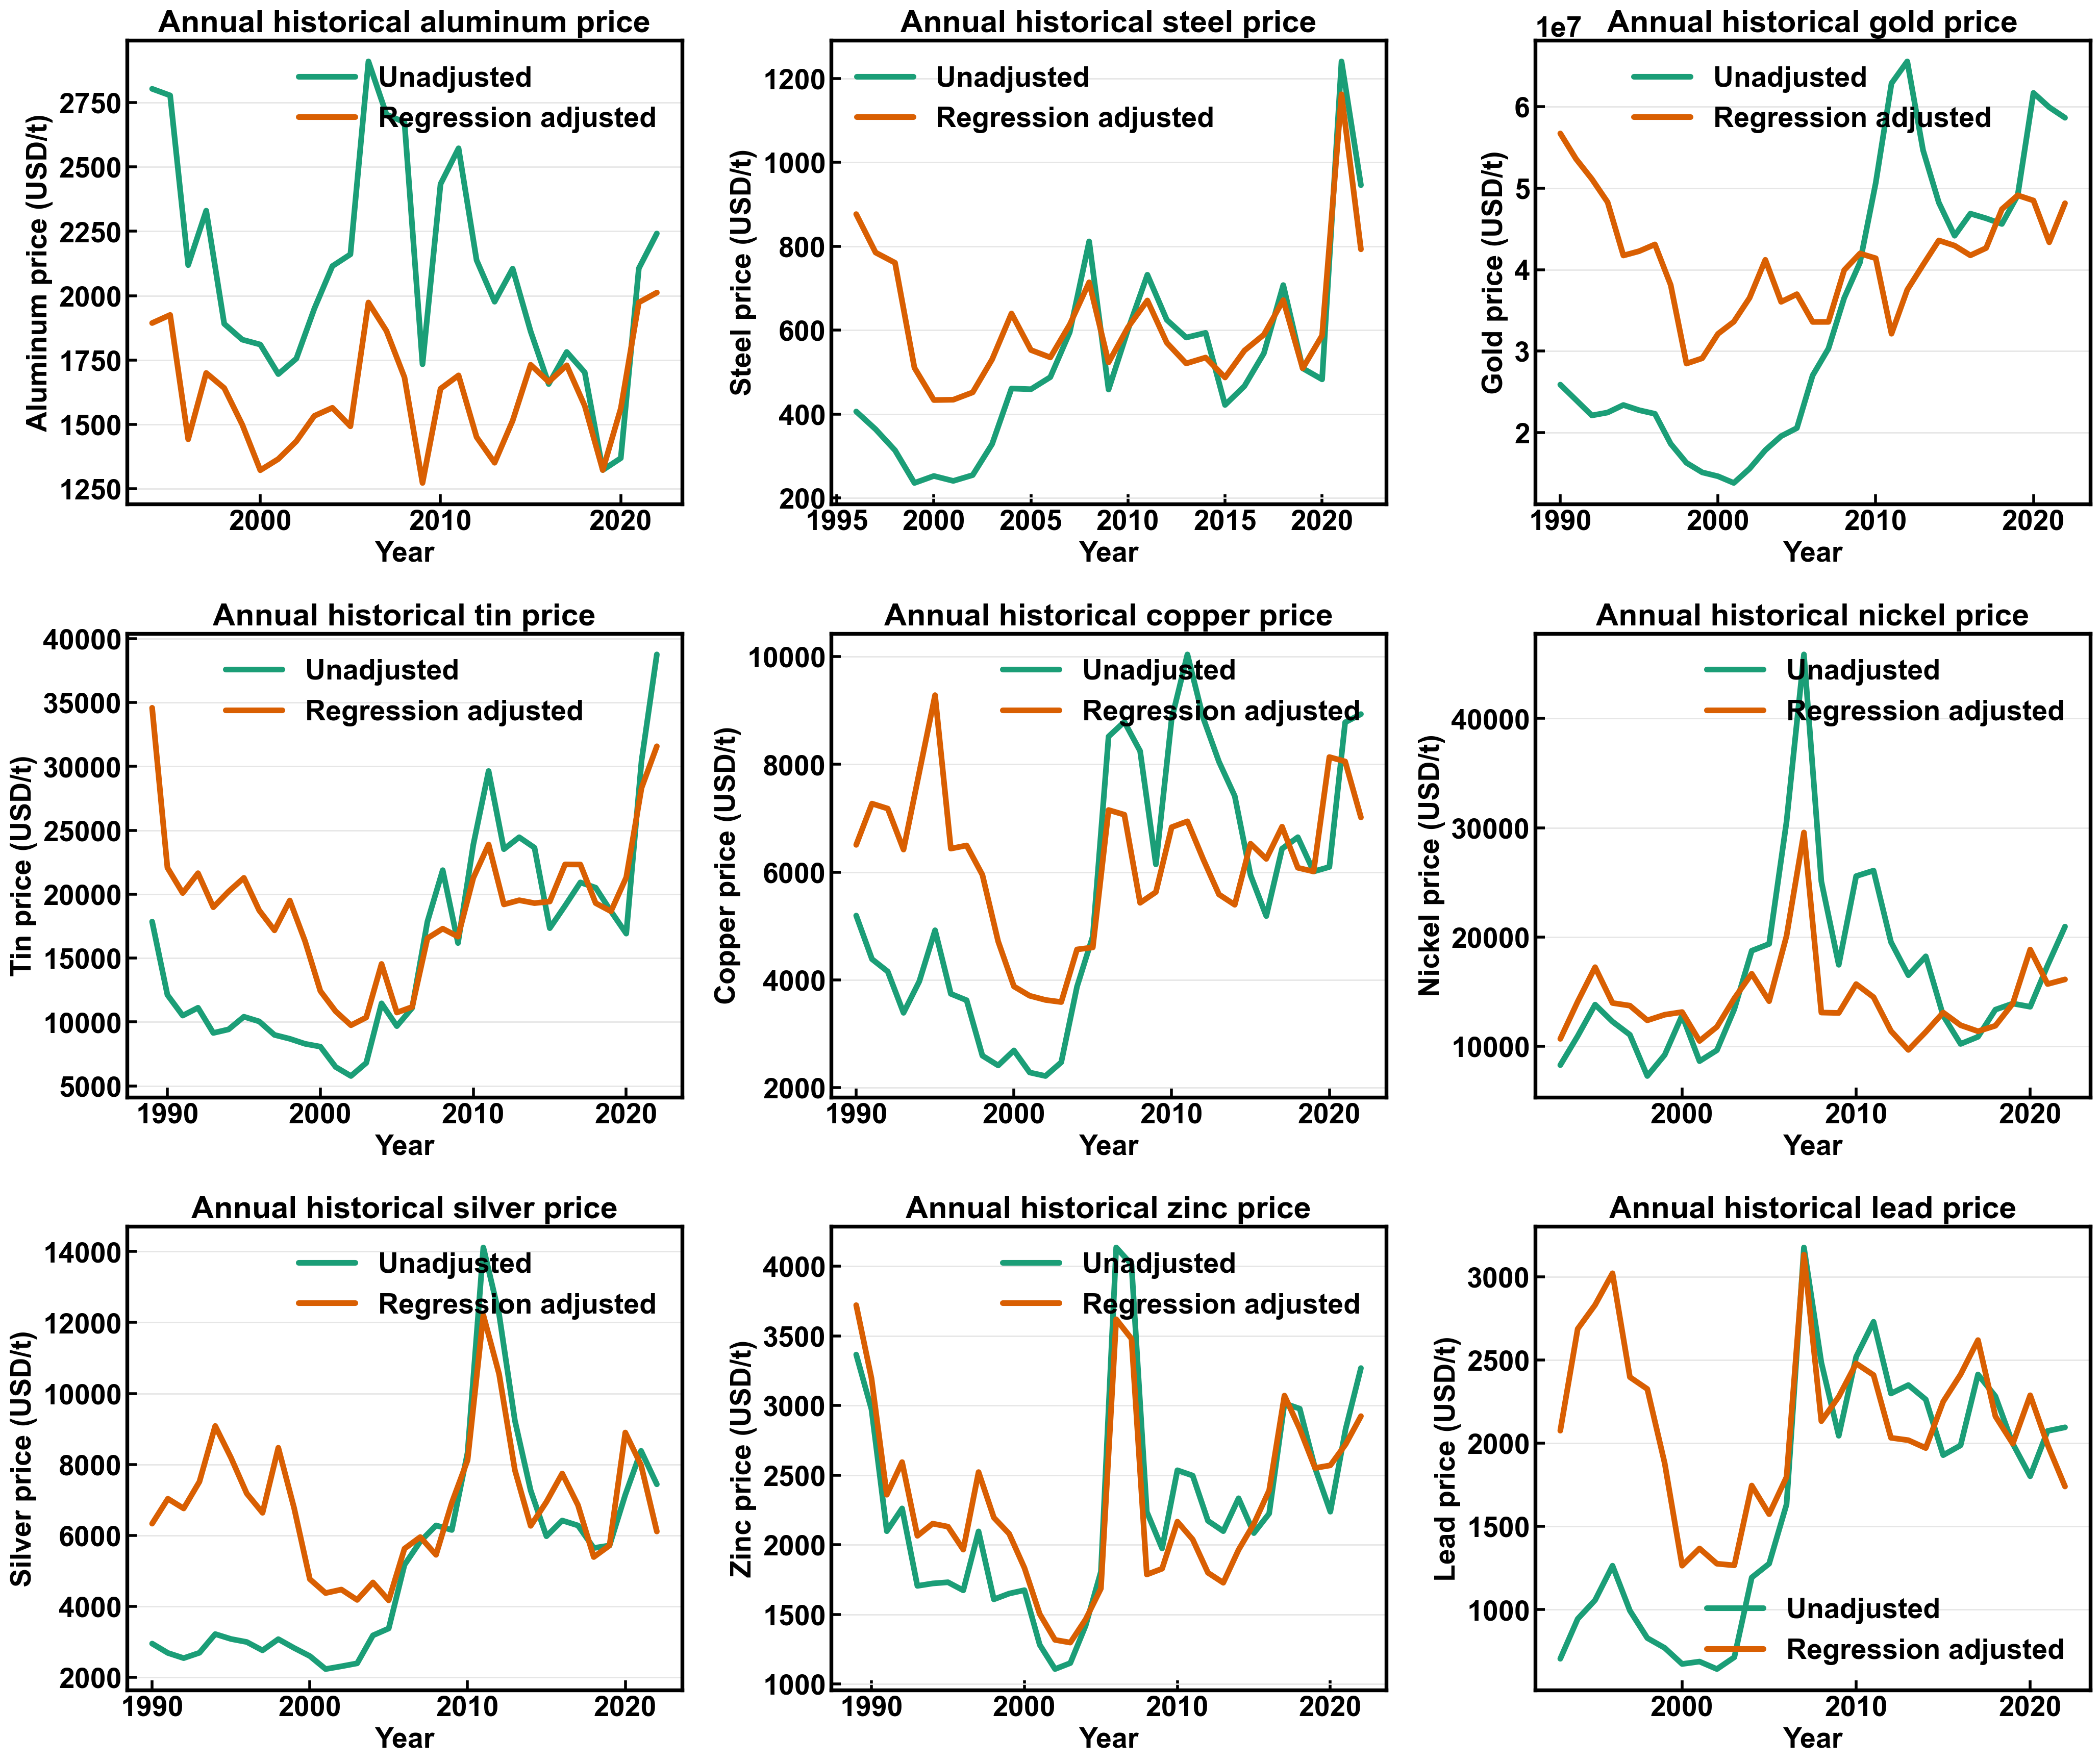

In [35]:
# pr = mod.price_results.copy()
pr = pd.read_excel('generalization/input_files/user_defined/price adjustment results.xlsx',index_col=0).sort_index()
pr = pr.loc[:,pr.loc[1996].notna()].sort_index()
coms = [i.split()[0] for i in pr.columns if 'original' in i and 'Platinum' not in i and ('Si' not in i or 'Silver' in i)]
fig,ax = easy_subplots(coms)
for a,i in zip(ax,coms):
    pr_ph = pr.loc[:,np.sort([j for j in pr.columns if i in j and '∆' not in j])]
    pr_ph.rename(columns={f'log({i})':'Regression adjusted',f'{i} original':'Unadjusted'},inplace=True)
    pr_ph.plot(ax=a).grid(axis='x')
    a.set(xlabel='Year',ylabel=f'{i} price (USD/t)')
    a.set_title(f'Annual historical {i.lower()} price',weight='bold')
fig.tight_layout()
fig.set_dpi(200)
# np.log(pr.loc[:,[i for i in pr.columns if 'log' in i]].sort_index()).plot()
# plt.legend(loc=(1.1,0))

In [117]:
mod.price_results.to_excel('generalization/data/price adjustment results.xlsx')
# price_results = pd.read_excel('generalization/data/price adjustment results.xlsx',index_col=0)

In [116]:
mod.price_results

,∆Aluminum,log(Aluminum),Aluminum original,∆Steel,log(Steel),Steel original,∆Gold,log(Gold),Gold original,∆Cobalt,...,Lead original,∆Molybdenum,log(Molybdenum),Molybdenum original,∆Platinum,log(Platinum),Platinum original,∆Lithium,log(Lithium),Lithium original
1994,3029.229999,1893.567210,2803.387739,NaN,NaN,NaN,2.768045e+07,4.173636e+07,2.338078e+07,NaN,...,944.670565,NaN,NaN,NaN,2.923089e+07,3.891188e+07,2.465348e+07,NaN,NaN,NaN
1995,2953.246861,1925.076828,2777.757654,NaN,NaN,NaN,2.740275e+07,4.226533e+07,2.274361e+07,NaN,...,1057.371553,NaN,NaN,NaN,2.947541e+07,3.834033e+07,2.511380e+07,NaN,NaN,NaN
1996,2259.322245,1442.079730,2118.637812,438.707767,861.910845,405.870494,2.736781e+07,4.309873e+07,2.230081e+07,NaN,...,1264.133267,NaN,NaN,NaN,2.633652e+07,3.174247e+07,2.283994e+07,NaN,NaN,NaN
1997,2492.788381,1699.685599,2330.080738,408.270570,779.248473,363.546856,2.406264e+07,3.811533e+07,1.861912e+07,NaN,...,994.112746,NaN,NaN,NaN,2.622779e+07,3.288188e+07,2.218385e+07,NaN,NaN,NaN
1998,2122.258023,1641.045271,1890.577893,377.065052,759.671291,313.382758,2.059100e+07,2.846619e+07,1.628006e+07,NaN,...,829.644411,NaN,NaN,NaN,2.635817e+07,3.944299e+07,2.059999e+07,NaN,NaN,NaN
1999,2014.180256,1498.949847,1829.080700,286.493437,518.365100,235.614821,2.025888e+07,2.911730e+07,1.510643e+07,NaN,...,770.371522,NaN,NaN,NaN,2.499948e+07,3.334511e+07,2.039901e+07,NaN,NaN,NaN
2000,1890.971075,1321.832857,1810.047893,274.486304,450.860265,252.242817,2.094527e+07,3.212069e+07,1.462768e+07,NaN,...,673.914231,NaN,NaN,NaN,3.051288e+07,3.354960e+07,2.850161e+07,NaN,NaN,NaN
2001,1826.881637,1365.309342,1695.297017,276.658067,447.537520,240.489188,2.060520e+07,3.360217e+07,1.380811e+07,NaN,...,688.351827,NaN,NaN,NaN,3.025029e+07,3.604191e+07,2.697989e+07,NaN,NaN,NaN
2002,1889.453327,1434.330243,1755.349164,291.193144,463.020752,254.331715,2.217007e+07,3.652928e+07,1.555954e+07,NaN,...,643.400012,NaN,NaN,NaN,3.036987e+07,3.646350e+07,2.703684e+07,NaN,NaN,NaN
2003,2041.796676,1533.013769,1949.571570,353.585076,543.886711,328.235011,2.453148e+07,4.120561e+07,1.783688e+07,NaN,...,714.442205,NaN,NaN,NaN,3.619520e+07,4.066999e+07,3.390304e+07,NaN,NaN,NaN


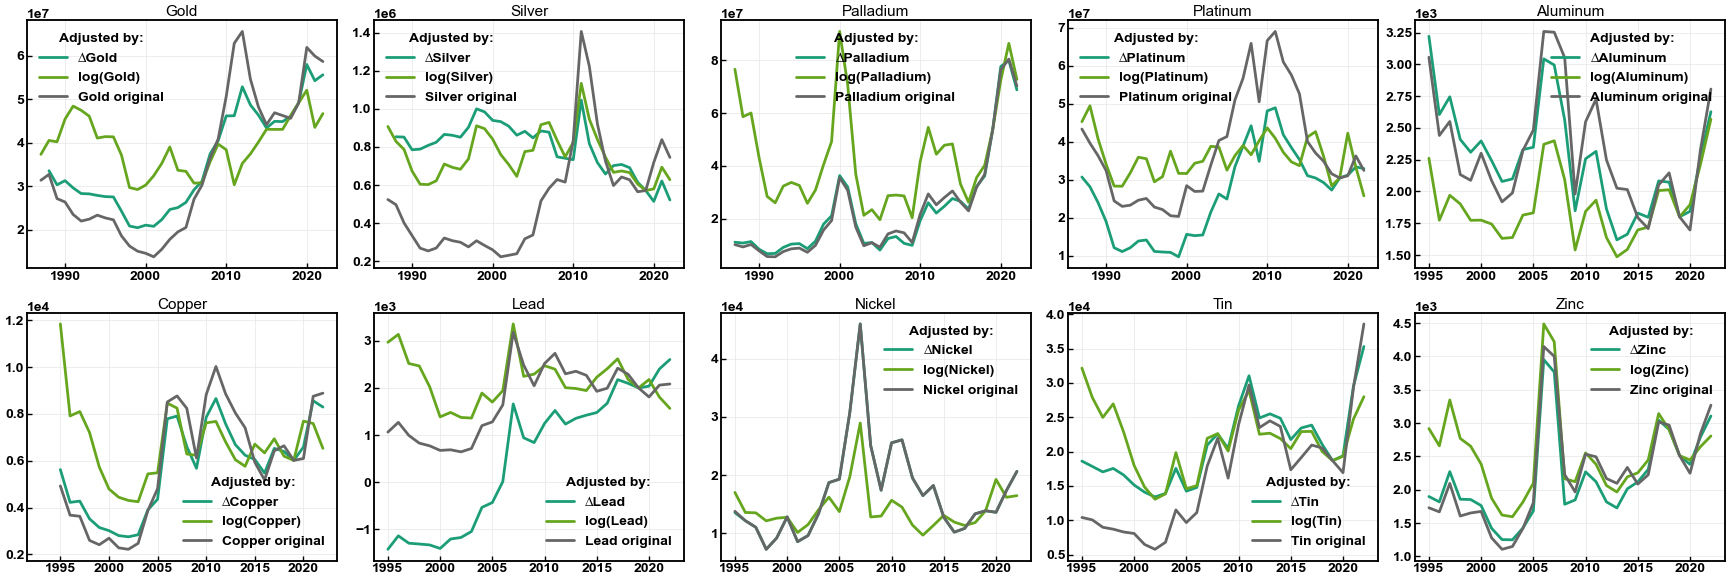

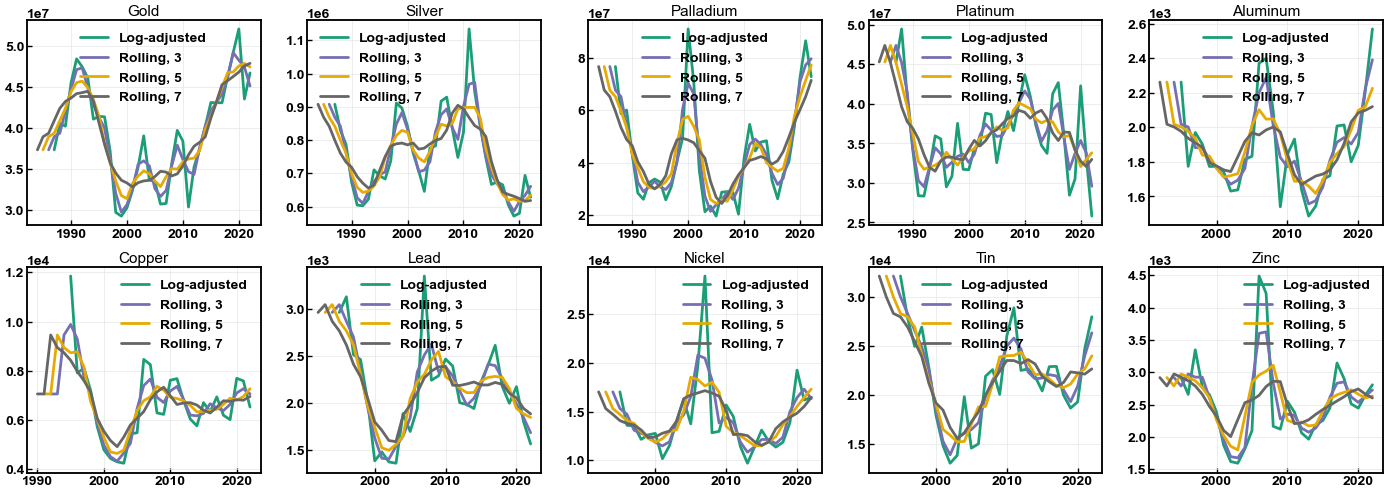

In [17]:
price_results = mod.price_results.copy().sort_index()
commodities = [i.split(' original')[0] for i in price_results.columns if 'original' in i and 'Midwest' not in i]
fig, ax = easy_subplots(commodities,ncol=5)
fig2,ax2= easy_subplots(commodities,ncol=5)
for i,a,b in zip(commodities,ax,ax2):
    if i=='Aluminum':
        cols = [j for j in price_results.columns if i in j and 'Midwest' not in j]
    else:
        cols = [j for j in price_results.columns if i in j]
    price_results.loc[:,cols].plot(ax=a,colormap='Dark2')
    a.set(title=i)
    a.ticklabel_format(scilimits=(0,2),axis='y')
    a.legend(title='Adjusted by:')
    
    col2 = [j for j in cols if 'log' in j]
    price = price_results.loc[:,col2]
    price_rolls = pd.concat([price,
               price.rolling(3,min_periods=1,center=True).mean(),
               price.rolling(5,min_periods=1,center=True).mean(),
               price.rolling(7,min_periods=1,center=True).mean()],
              axis=1,keys=['Log-adjusted','Rolling, 3','Rolling, 5','Rolling, 7']).droplevel(1,axis=1)
    price_rolls.plot(ax=b,colormap='Dark2')
    b.set(title=i)
    b.ticklabel_format(scilimits=(0,2),axis='y')
fig.tight_layout()

In [457]:
commodities = [i.split(' original')[0] for i in price_results.columns if 'original' in i and 'Midwest' not in i]
# fig, ax = easy_subplots(commodities,ncol=5)
# fig2,ax2= easy_subplots(commodities,ncol=5)
# for i,a,b in zip(commodities,ax,ax2):
#     if i=='Aluminum':
#         cols = [j for j in price_results.columns if i in j and 'Midwest' not in j]
#     else:
#         cols = [j for j in price_results.columns if i in j]
#     normed_stds.loc[:,cols].plot(ax=a,colormap='Dark2')
#     a.set(title=i)
#     a.ticklabel_format(scilimits=(0,2),axis='y')
#     a.legend(title='Adjusted by:')

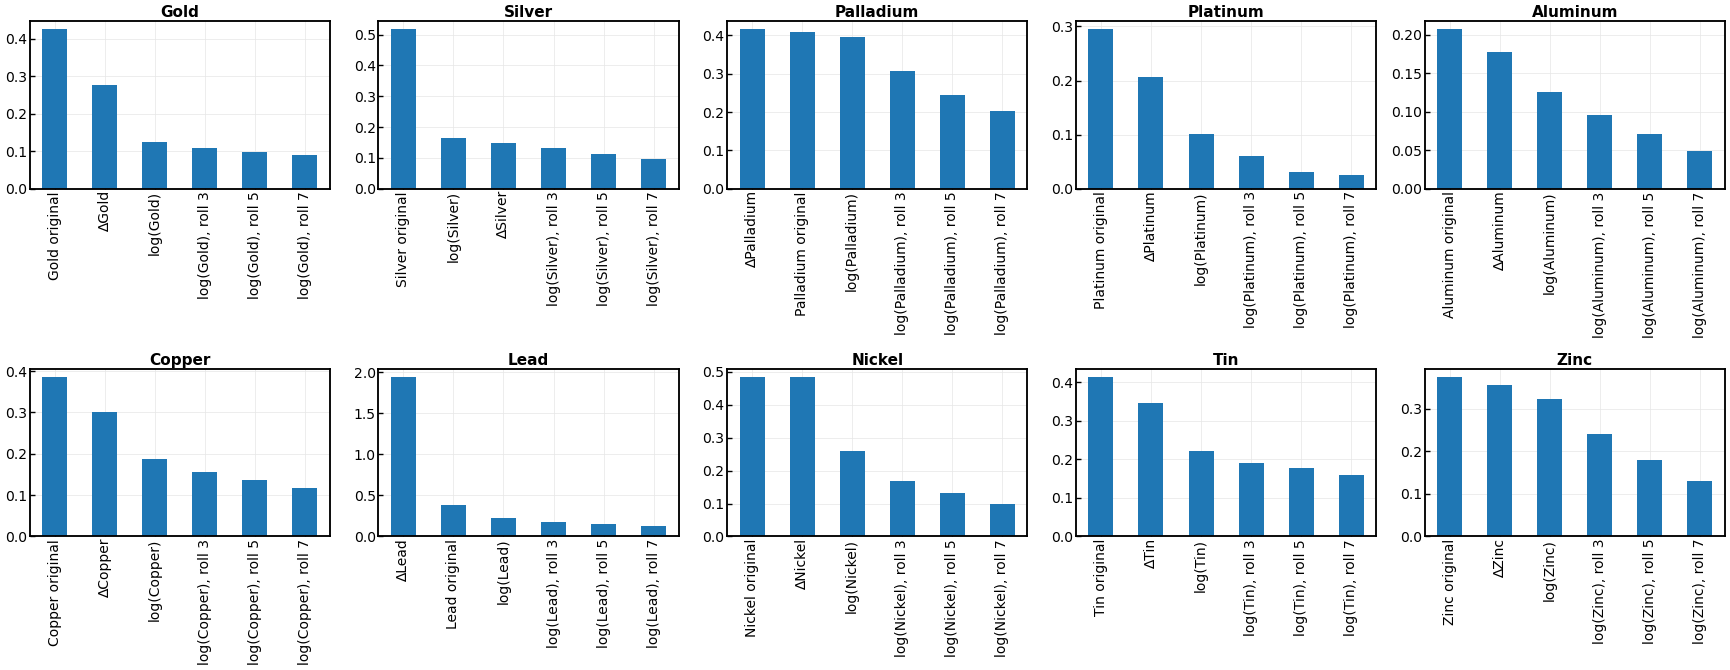

In [475]:
normed_stds = price_results.std()/price_results.mean()
for i in [3,5,7]:
    p1 = price_results.rolling(i,min_periods=1,center=True).mean()
    p1 = p1.std()/p1.mean()
    p1 = p1.loc[[i for i in p1.index if 'log' in i]]
    p1 = p1.rename(dict(zip(p1.index,[j+', roll '+str(i) for j in p1.index])))
    normed_stds = pd.concat([normed_stds,p1])
    
commodities = [i.split(' original')[0] for i in price_results.columns if 'original' in i and 'Midwest' not in i]
fig, ax = easy_subplots(commodities,ncol=5,height_scale=1.15)
for i,a in zip(commodities,ax):
    if i=='Aluminum':
        cols = [j for j in normed_stds.index if i in j and 'Midwest' not in j]
    else:
        cols = [j for j in normed_stds.index if i in j]
    normed_stds.loc[cols].sort_values(ascending=False).plot.bar(ax=a)
    a.set(title=i)
fig.tight_layout()

In [466]:
cols

['∆Zinc',
 'log(Zinc)',
 'Zinc original',
 'log(Zinc), rolling 3',
 'log(Zinc), rolling 5',
 'log(Zinc), rolling 7']

<AxesSubplot:>

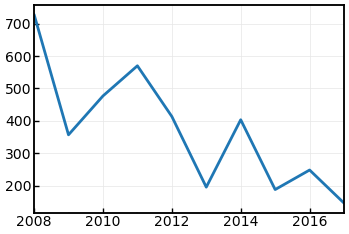

In [314]:
price_daily=pd.read_excel('generalization/data/Price inputs.xlsx',sheet_name='AMM',index_col=0)['Steel'].iloc[1:].dropna().sort_index()
price_daily.index = pd.to_datetime(price_daily.index)
price_monthly = price_daily.resample('AS').mean()
price_monthly.plot()

# Checking Midwest Premium vs LME

In [137]:
price_daily=pd.read_excel('data/Price inputs.xlsx',sheet_name='AMM',index_col=0).iloc[1:].loc[:,['Aluminum Midwest Premium','Aluminum']].dropna(how='all').astype(float)
price_daily_mw=pd.read_excel('data/Price inputs.xlsx',sheet_name='AMM',index_col=0).iloc[1:].loc[:,'Aluminum Midwest Premium'].dropna().astype(float)
price_daily_mw=price_daily_mw.loc[price_daily_mw<500]
price_daily_sp=pd.read_excel('data/Price inputs.xlsx',sheet_name='LME-SP Global',index_col=0)['LME-Aluminium 99.7% Cash ($/tonne)'].dropna().iloc[:-1].astype(float)
price_daily.loc[:,'Aluminum'] /= 22.0462
price_daily.rename(columns={'Aluminum':'LME','Aluminum Midwest Premium':'Midwest Premium'},inplace=True)
price_daily = price_daily.sort_index()
price_daily = price_daily.loc[price_daily.index>datetime.datetime(2009,1,1)]
price_daily = price_daily.loc[(price_daily<250).all(axis=1)]
price_daily.index = pd.to_datetime(price_daily.index)
price_monthly = price_daily.resample('MS').mean()
price_annual = price_daily.resample('AS').mean()

In [177]:
price_daily_sp.name='better lme'
better_daily = np.log(pd.concat([price_daily_mw,price_daily_sp],axis=1))
better_daily.dropna()
m = sm.GLS(better_daily.dropna()['Aluminum Midwest Premium'],sm.add_constant(better_daily.dropna()['better lme'])).fit(cov_type='HC3')
new_midwest = np.exp(m.predict(sm.add_constant(better_daily.loc[better_daily.index>better_daily.dropna().index[0],'better lme'])))
updated_midwest = pd.concat([np.exp(better_daily['Aluminum Midwest Premium']),new_midwest]).dropna().sort_index()
updated_midwest = updated_midwest.mul(22.0462)

cpi_monthly = pd.read_excel('data/Price inputs.xlsx',sheet_name='CPI',index_col=0).loc[:,:'Dec'].iloc[1:].stack().dropna()
cpi_monthly.index = [str(i[0])+'-'+i[1] for i in cpi_monthly.index]
cpi_monthly.index = pd.to_datetime(cpi_monthly.index)
cpi_monthly = cpi_monthly.sort_index()
deflator = cpi_monthly.copy()/cpi_monthly.resample('AS').mean().loc['20190101']
cpi_monthly /= cpi_monthly.loc['20190101']

mw_infl_adj = updated_midwest.resample('MS').mean()/cpi_monthly
# updated_midwest.to_clipboard()
updated_midwest.resample('MS').mean().to_clipboard()
# updated_midwest.resample('AS').mean().to_clipboard()

mw_infl_adj.to_clipboard()
mw_infl_adj.resample('AS').mean().to_clipboard()

<AxesSubplot:>

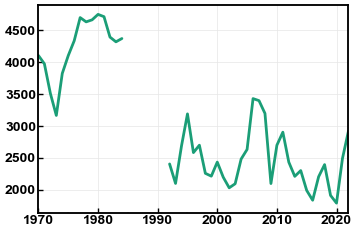

In [178]:
mw_infl_adj.resample('AS').mean().plot()

In [670]:
plot = False
class Pred():
    def __init__(self,price_diff,split):
        train = price_diff.iloc[:int(price_diff.shape[0]*split)]
        test = price_diff.loc[~price_diff.index.isin(train.index)]

        self.train = train.copy()
        self.test = test.copy()
        m = sm.GLS(train.loc[:,'Midwest Premium'],sm.add_constant(train.loc[:,'LME'])).fit(cov_type='HC3')
        predicted = m.predict(sm.add_constant(test.loc[:,'LME']))
        self.predicted = predicted.copy()
        m = sm.GLS(predicted, sm.add_constant(test.loc[:,'Midwest Premium'])).fit(cov_type='HC3')
        self.m = m
        
        
def create_df(split,plot=False,price_daily=price_daily, price_annual=price_annual, price_monthly=price_monthly,ax=ax):
    df = pd.DataFrame()
    for p,i,a in zip([price_daily, price_monthly, price_annual],['Daily','Monthly','Annual'],ax):
        if plot:
            p.plot(ax=a,title=i,ylabel='Price (¢/lb)',xlabel='Year')
        price_diff = p.diff().dropna()
        m = sm.GLS(price_diff.loc[:,'Midwest Premium'],sm.add_constant(price_diff.loc[:,'LME'])).fit(cov_type='HC3')
        df.loc[i,'full m'] = m
        df.loc[i,'full r2'] = m.rsquared

#         pred = Pred(price_diff,split)
#         predicted_price = p.loc[pred.predicted.index[0],'Midwest Premium']+pred.predicted.cumsum()
#         ind = p.drop(predicted_price.index).index[-1]
#         predicted_price.loc[ind] = p.loc[ind,'Midwest Premium']
#         predicted_price.sort_index(inplace=True)
#         pred.hist_sim = pd.concat([p.loc[:,'Midwest Premium'],predicted_price],axis=1)
#         pred.hist_sim.columns = ['Historical','Predicted from LME']
        
#         df.loc[i,'p'] = pred
#         df.loc[i,'predict r2'] = pred.m.rsquared
    return df
    
bigger_df = pd.DataFrame()
for split in np.arange(0.1,0.901,0.02):
    split = round(split,2)
    if plot:
        fig, ax = easy_subplots(3)
    else: ax = [0,0,0]
    df = create_df(split,plot,price_daily,price_annual,price_monthly,ax)
        
    df = pd.concat([df],keys=[split])
    bigger_df = pd.concat([bigger_df,df])

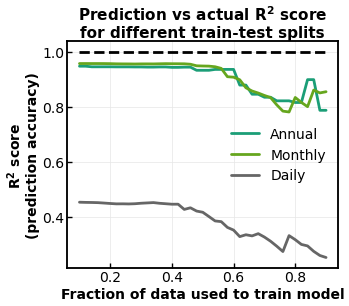

In [627]:
fig,ax = easy_subplots(1)
a = ax[0]
bigger_df['predict r2'].unstack().loc[:,['Annual','Monthly','Daily']].plot(
    ax=a,
    colormap='Dark2',
    title=r'Prediction vs actual $R^2$ score'+'\nfor different train-test splits',
    ylabel=r'$R^2$ score'+'\n(prediction accuracy)',
    xlabel='Fraction of data used to train model'
)
plt.hlines(1,bigger_df.index.get_level_values(0).min(),bigger_df.index.get_level_values(0).max(),color='k',linestyle='--')


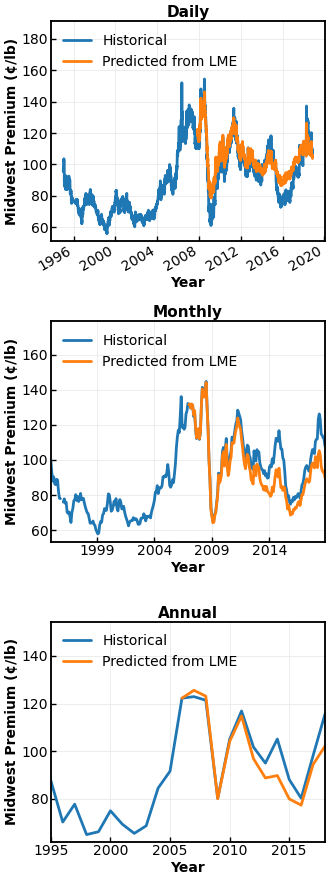

In [649]:
fig,ax = easy_subplots(bigger_df.index.get_level_values(1).unique(),ncol=1)
for i,a in zip(bigger_df.index.get_level_values(1).unique(),ax):
    bigger_df.loc[0.5].p[i].hist_sim.plot(ax=a)
    a.legend(loc='upper left')
    a.set(
        ylim=(a.get_ylim()[0],a.get_ylim()[1]*1.2),
        title=i,
        xlabel='Year',
        ylabel='Midwest Premium (¢/lb)',
    )
fig.tight_layout()

<AxesSubplot:ylabel='¢/lb'>

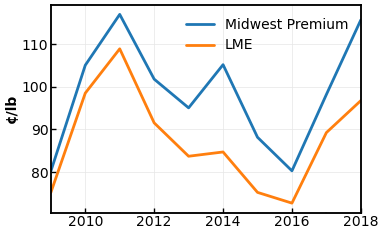

In [666]:
price_annual.plot(ylabel='¢/lb')

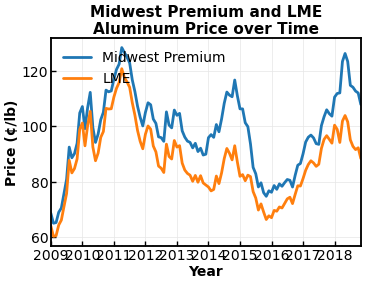

In [667]:
price_monthly.plot(
    title='Midwest Premium and LME\nAluminum Price over Time',
    xlabel='Year',
    ylabel='Price (¢/lb)'
)
plt.legend(loc='upper left')

In [671]:
df['full r2']

0.9  Daily      0.376199
     Monthly    0.908170
     Annual     0.878437
Name: full r2, dtype: float64

# Plotting historical primary production

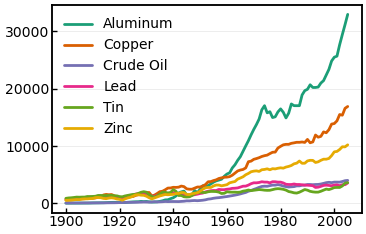

In [857]:
priprod = pd.read_excel('/Users/johnryter/Dropbox (MIT)/Group Research Folder_Olivetti/Displacement/08 Generalization/Mining/Mineral production - What drives mineral production Martin Sturmer.xlsx')
matls = np.unique([i.split('.')[0] for i in priprod.columns])
mat_dict = dict(zip(priprod.columns[0::2],priprod.columns[1::2]))
mat_dict_rev = dict(zip(priprod.columns[1::2],priprod.columns[0::2]))
i = matls[0]
merged_priprod = pd.concat([
    np.exp(priprod.set_index(i).rename(columns=mat_dict_rev)[i].dropna()) for i in matls],keys=matls,axis=1).sort_index()
not_gdp = merged_priprod.loc[1900:2005,[i for i in merged_priprod.columns if 'GDP' not in i]]
not_gdp.plot(logy=False).grid(axis='x')
# priprod
# matls

[Text(0.5, 1.0, 'World mine production'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Mine production\n(thousand metric tons)')]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Calibri
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Calibri


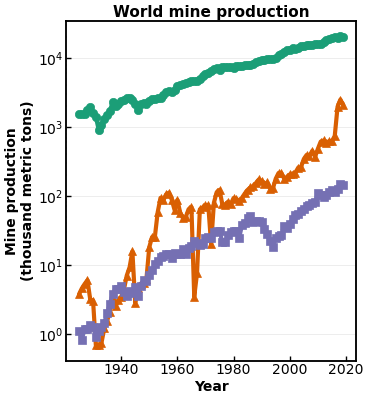

In [8]:
usgs = pd.read_excel('/Users/johnryter/Dropbox (MIT)/Group Research Folder_Olivetti/Displacement/08 Generalization/Mining/Mineral production - What drives mineral production Martin Sturmer.xlsx',sheet_name='USGS',index_col=0).dropna()
# usgs.apply(lambda x: x/x.loc[2000]).plot()
fig = plt.figure(figsize=(7.5,9),dpi=50)
ax = fig.add_subplot()
sns.set_palette('Dark2')
usgs.plot(logy=True,ax=ax,legend=False,linewidth=6).grid(axis='x')
ax.set(title='World mine production',xlabel='Year',ylabel='Mine production\n(thousand metric tons)')

# Making a supply demand gap plot

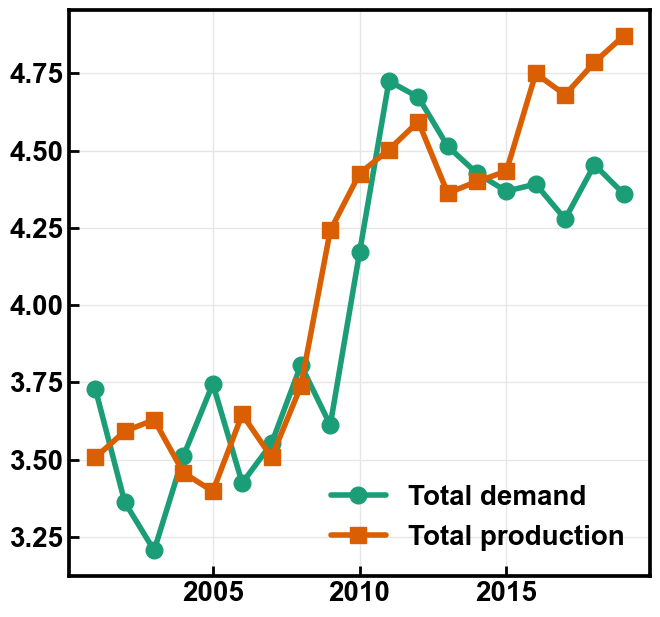

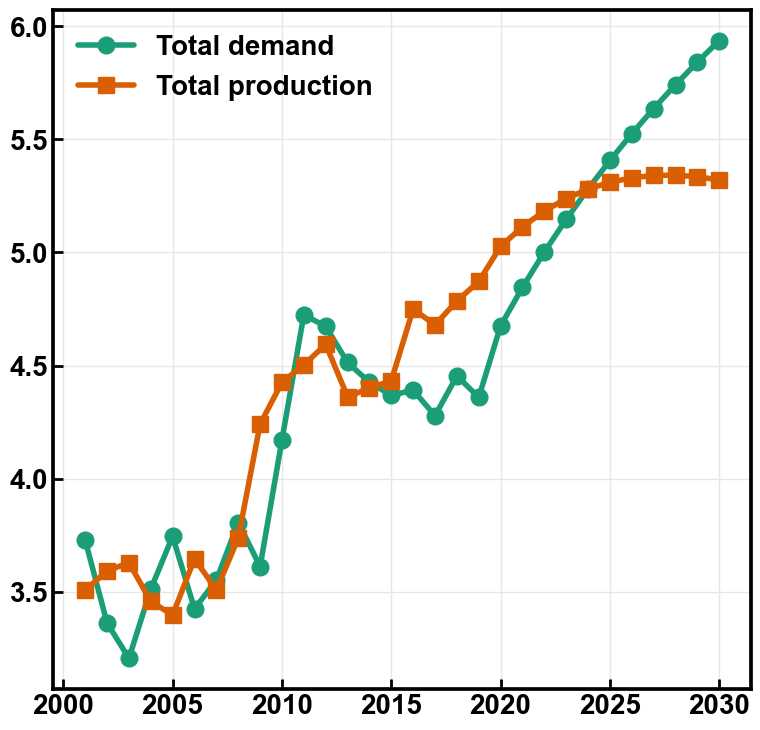

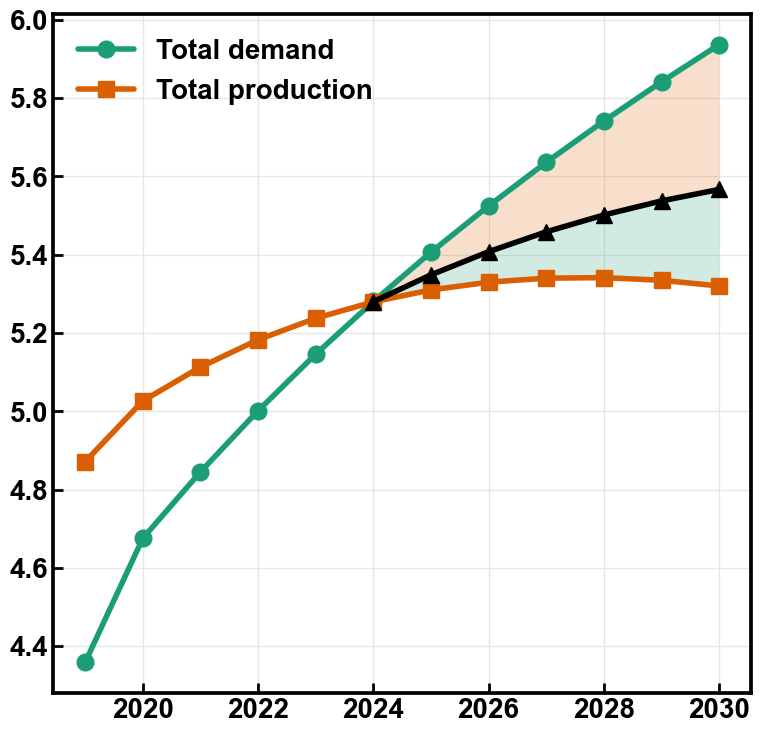

In [11]:
dpi=100
figsize=(7.5,7.5)
pr = pd.read_excel('generalization/data/case study data.xlsx',sheet_name='Au',index_col=0).drop('Source(s)')
pr_new=pr[['Total demand','Total production']].copy()
fig = plt.figure(figsize=figsize,dpi=dpi)
ax=fig.add_subplot()
pr_new.plot(ax=ax)
pr_add1 = pd.Series([pr_new['Total demand'][2019]*1.03*np.log10(x+10) for x in np.arange(1,12)],np.arange(2020,2031))
pr_add2 = pd.Series([pr_new['Total production'][2019]*(1.01*np.log10((x+10))-1.02**x+1)for x in np.arange(1,12)],np.arange(2020,2031))
figsize=(9,9)
fig = plt.figure(figsize=figsize,dpi=dpi)
ax=fig.add_subplot()
pr_future = pd.concat([pr_new,pd.concat([pr_add1,pr_add2],axis=1,keys=['Total demand','Total production'])])
pr_future.plot(ax=ax)
fig = plt.figure(figsize=figsize,dpi=dpi)
ax=fig.add_subplot()
pr_sub = pr_future.loc[2019:].astype(float)
# pr_sub.plot(ax=ax)
midpoint = pr_sub.iloc[:,0]*0.4+pr_sub.iloc[:,1]*0.6
midpoint = midpoint.loc[pr_sub['Total production']<pr_sub['Total demand']]

pr_sub.plot(ax=ax)
midpoint.plot(ax=ax,color='k')
plt.fill_between(midpoint.index.astype(float),pr_sub.loc[midpoint.index,'Total production'],midpoint,alpha=0.2)
plt.fill_between(midpoint.index.astype(float),pr_sub.loc[midpoint.index,'Total demand'],midpoint,alpha=0.2)